In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,400,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))


## prepare training and testing data

In [2]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [3]:

def normalize_X(clean_series):

    recover_dic={}
    scaled_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            scaled_series.append(np.zeros_like(clean_series[i]))
            recover_dic[i]=(0,0)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            recover_dic[i]=(std,biased_mean)
            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series,recover_dic)


def normalize_Y(clean_series,recover_dic):
    scaled_series=[]
    for i in range(len(clean_series)):
        (std,biased_mean) = recover_dic[i]
        
        if std==0:
            # ignore all zero cases
#             print(clean_series[i])
            scaled_series.append(np.zeros_like(clean_series[i]))

        else:
            

            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series)

def recover(scaled_series,recover_dic):
    recovered_series=[]
    for i in range(len(scaled_series)):
        std,biased_mean=recover_dic[i]
        new_series=scaled_series[i]*(6*float(std))+biased_mean
        recovered_series.append(new_series)
    return recovered_series

In [160]:
aa,dic=normalize_X(clean_series)

In [161]:
bb=recover(aa,dic)

In [6]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
train_x,train_dic = normalize_X(clean_series)
train_y = normalize_Y(decode_series,train_dic)


encode_start=200
encode_end=350
decode_len=63


clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x,test_dic = normalize_X(clean_series)
test_y = normalize_Y(decode_series,test_dic)

In [184]:
# plt.plot(np.concatenate((train_x[18],train_y[18]),axis=0))

In [7]:
def X_loader(x,batchsize=10):
    batch=0
    x=np.array(x,dtype=np.float32)
#     x=np.log(x+1)
    
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
#         tensor=tensor.repeat(1,1,25)
        yield(tensor)
        batch+=1

In [8]:

def Y_loader(y,batchsize=10):
    batch=0
    y=np.array(y,dtype=np.float32)
#     y=np.log(y+1)
    
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        yield(tensor)
        batch+=1

In [9]:
import torch
import torch.nn as nn


In [18]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print (name, param.data)

gru.weight_ih_l0 tensor([[ 0.5137],
        [-0.4497],
        [ 0.3978]], device='cuda:0')
gru.weight_hh_l0 tensor([[ 0.5945],
        [-0.1228],
        [ 0.7839]], device='cuda:0')
gru.bias_ih_l0 tensor([ 0.0366, -0.4584,  1.3032], device='cuda:0')
gru.bias_hh_l0 tensor([ 0.3414, -0.9296,  1.3885], device='cuda:0')


In [19]:
import numpy

def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

In [55]:
x=0.4
h=1
r1=-0.3818*x-0.6236-0.0479*h-0.6173
print(r1)
r=sigmoid(r1)
r

-1.44152


0.19131007820695337

In [43]:
z=sigmoid(-0.3851*x+0.6046+0.3549*x-0.4002)
z

0.5494280370459982

In [44]:
n1=(0.1743*x+0.1921)
print(n1)
n2=(0.3714*x+1.5644+r*n1)
print(n2)
n=np.tanh(sigmoid(n2))
n

0.22696
1.6848443328167804


0.6876821322670081

In [45]:
out=(1-z)*n+z*h
out

0.8592783252699375

In [24]:
trainx=X_loader(train_x)
sample=next(trainx)

In [25]:
sample[:,3:4,:]

tensor([[[ 0.2080]],

        [[ 0.2724]],

        [[ 0.3864]],

        [[ 0.9286]],

        [[ 0.4617]],

        [[ 0.3999]],

        [[ 0.3935]],

        [[ 0.6377]],

        [[ 0.5955]],

        [[ 0.4381]]], device='cuda:0')

In [85]:
oo

tensor([[[ 1.]]], device='cuda:0')

In [57]:
decoder(sample[:,6:7,:],oo)

(tensor([[[ 0.9619]],
 
         [[ 0.9904]],
 
         [[ 0.9972]],
 
         [[ 0.9990]],
 
         [[ 0.9996]],
 
         [[ 0.9997]],
 
         [[ 0.9997]],
 
         [[ 0.9998]],
 
         [[ 0.9998]],
 
         [[ 0.9998]]], device='cuda:0'),
 tensor([[[ 0.9998]]], device='cuda:0'))

In [11]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
#     true=torch.exp(true)-1
#     predicted=torch.exp(predicted)-1
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [51]:
from torch import optim
from numpy import random as random
epoch=1
indicator=20

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
input_size=1
hidden_size=1
output_size=1
lr=0.01

encoder=EncoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else DecoderRNN(1,hidden_size)
teacher_forcing_ratio = 0
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

In [58]:
for i in range(epoch):
    trainx=X_loader(train_x)
    trainy=Y_loader(train_y)
    running_loss = 0.0
#     validation(test_x,test_y)
    for j,X_batch in enumerate(trainx):
        #Parse loaded batch
        x=X_batch
        y=next(trainy)
        (loss,oo)=train(x, y, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss += loss

        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; Loss: {}\n".format(i, j, running_loss / indicator))
            running_loss = 0.0
    _,_,score = valid_iter(test_x, test_y)
    print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))

In [148]:
preds,targets,scores=valid_iter(test_x,test_y)

[13.259035 25.032623 26.540068 26.56335  26.567204 26.567862 26.567972
 26.567991 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995
 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995 26.567995]


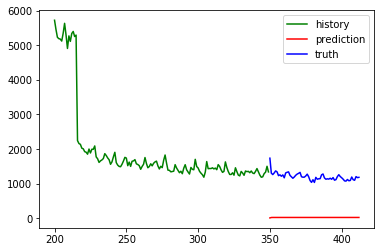

In [124]:
ID=40
source=sample_series[ID][encode_start:encode_end]
pred=preds[ID]
truth=targets[ID]
print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start,encode_end),source,color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [56]:
# preds[0]

In [12]:
def valid_iter(test_x,test_y):
    testx=X_loader(test_x)
    testy=Y_loader(test_y)

    preds=[]
    targets=[]

    scores=[]
    for j,X_batch in enumerate(testx):
        #Parse loaded batch
        print(j,end='\r')
        target=next(testy)
        score,out = valid(X_batch, target, encoder, decoder, SMAPE)
        out=out.T
        scores.append(score)
        target=target.squeeze().detach().cpu().numpy()
        if j ==0:
            preds=out
            targets=target
        else:
            preds=np.concatenate((preds,out),axis=0)
            targets=np.concatenate((targets,target),axis=0)
    return (preds,targets,scores)

In [13]:
# preds

In [50]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):

        output, hidden = self.gru(input, hidden)
#         output = self.out(output)
        return output, hidden

    def initHidden(self):
        
#         nn.init.xavier_normal_(self.out)
        paras= nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size))
        return paras

class DecoderRNN(nn.Module):
    def __init__(self, input_size,hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)


    def forward(self, input, hidden):

        output, hidden = self.gru(input, hidden)
#         output = self.out(output)
        return output, hidden

    def initHidden(self):
        paras= nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size))
        return paras


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
    encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length-1):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:], encoder_hidden)
        loss += criterion(encoder_output,input_variable[:,ei+1:(ei+2),:])
        encoder_outputs[ei] = encoder_output[0,0]
    #get the first prediction
    encoder_output, encoder_hidden = encoder(input_variable[:,ei+1:(ei+2),:], encoder_hidden)
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
    oo=encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
#             print(decoder_hidden.size())
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_variable[:,di:di+1,:])
            decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

    else:
        print('real start')
        print(input_variable[:,ei:(ei+1),:])
        print('encode start')
        print(decoder_input)
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
#             print(decoder_hidden.size())
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            decoder_input = decoder_output
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
#             print('sizes')
#             print(decoder_output.size(),target_variable[:,di:di+1,:].size())
#             print('hidden')
#             print(decoder_hidden)
#             oo=decoder_hidden
#             print('pred')
#             print(decoder_output)
            
#             print('truth')
#             print(target_variable[:,di:di+1,:])
#             print('-'*90)
            loss += criterion(decoder_output, target_variable[:,di:di+1,:])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length,encoder_hidden

In [15]:
def valid(input_variable, target_variable, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    encoder_hidden = encoder.initHidden()
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
#     print(target_length)
    
    loss = 0

    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:], encoder_hidden)
    
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             loss += criterion(decoder_output, target_variable[:,di:di+1,:])
#             decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

#     else:
        # Without teacher forcing: use its own predictions as the next input
    outputs=[]

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)

        decoder_input = decoder_output
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        outputs.append(decoder_output.squeeze().detach().cpu().numpy())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
        loss += criterion(decoder_output, target_variable[:,di:di+1,:])


    return (loss.item() / target_length,np.array(outputs))